In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class ReLU_MaxNN2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ReLU_MaxNN2, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        hidden_out = self.relu(self.hidden(x))
        output = self.output(hidden_out)

        return self.relu(output)
#MODEL CLASS DOES NOT HAVE RLU ON OUTPUT

In [3]:
from sklearn.model_selection import train_test_split

learning_rate = 0.001
epochs = 5000
num_samples = 100000

results = []

input_sizes = [3]
hidden_sizes = [x+1 for x in range(10)]

for input_size in input_sizes:
    for hidden_size in hidden_sizes:

        X = torch.rand(num_samples, input_size) * 20 - 10  #Random inputs between -10 and 10
        Y = torch.max(X, dim=1, keepdim=True)[0]  #True max

        #DATA IS TRUE VALUE
        #Split into training and testing data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X.numpy(), Y.numpy(), test_size=0.2, random_state=42
        )
        X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
        Y_train, Y_test = torch.tensor(Y_train), torch.tensor(Y_test)

        model = ReLU_MaxNN2(input_size, hidden_size)
        criterion = nn.MSELoss()  #Mean Squared Error loss
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, Y_train)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, Y_test).item()

        results.append({
            'input_size': input_size,
            'hidden_size': hidden_size,
            'training_loss': loss.item(),
            'testing_loss': test_loss
        })

In [4]:
import pandas as pd

results_df = pd.DataFrame(results)

results_df.to_csv("model_training_prediction_max.csv", index=False)
print("Results saved to model_training_prediction_max.csv")

print(results_df)

Results saved to model_training_prediction_max.csv
   input_size  hidden_size  training_loss  testing_loss
0           3            1       6.342737      6.273100
1           3            2       5.841757      5.731822
2           3            3       4.165321      4.115490
3           3            4       2.014081      1.991451
4           3            5       1.681725      1.651089
5           3            6       1.541345      1.537566
6           3            7       1.462627      1.400525
7           3            8       1.535508      1.573211
8           3            9       1.469277      1.466099
9           3           10       1.443400      1.412649


In [5]:
df = pd.read_csv("model_training_prediction_max.csv")

min_loss = df["testing_loss"].min()

epsilon = 0.05  #Allowable margin for loss

filtered_df = df[df["testing_loss"] <= min_loss + epsilon]

best_model = filtered_df.sort_values(by="hidden_size").iloc[0]

print("Best Model:")
print(best_model)

Best Model:
input_size       3.000000
hidden_size      7.000000
training_loss    1.462627
testing_loss     1.400525
Name: 6, dtype: float64


Best model has 7 hidden units with testing loss 1.4005
Epoch [100/5000], Train Loss: 26.7492, Test Loss: 26.8198
Epoch [200/5000], Train Loss: 14.5621, Test Loss: 14.5526
Epoch [300/5000], Train Loss: 7.6619, Test Loss: 7.6226
Epoch [400/5000], Train Loss: 4.6380, Test Loss: 4.6002
Epoch [500/5000], Train Loss: 3.2992, Test Loss: 3.2911
Epoch [600/5000], Train Loss: 2.7310, Test Loss: 2.7331
Epoch [700/5000], Train Loss: 2.4412, Test Loss: 2.4491
Epoch [800/5000], Train Loss: 2.3016, Test Loss: 2.3127
Epoch [900/5000], Train Loss: 2.2342, Test Loss: 2.2461
Epoch [1000/5000], Train Loss: 2.1951, Test Loss: 2.2071
Epoch [1100/5000], Train Loss: 2.1669, Test Loss: 2.1790
Epoch [1200/5000], Train Loss: 2.1435, Test Loss: 2.1558
Epoch [1300/5000], Train Loss: 2.1229, Test Loss: 2.1354
Epoch [1400/5000], Train Loss: 2.1044, Test Loss: 2.1171
Epoch [1500/5000], Train Loss: 2.0877, Test Loss: 2.1006
Epoch [1600/5000], Train Loss: 2.0723, Test Loss: 2.0855
Epoch [1700/5000], Train Loss: 2.0581,

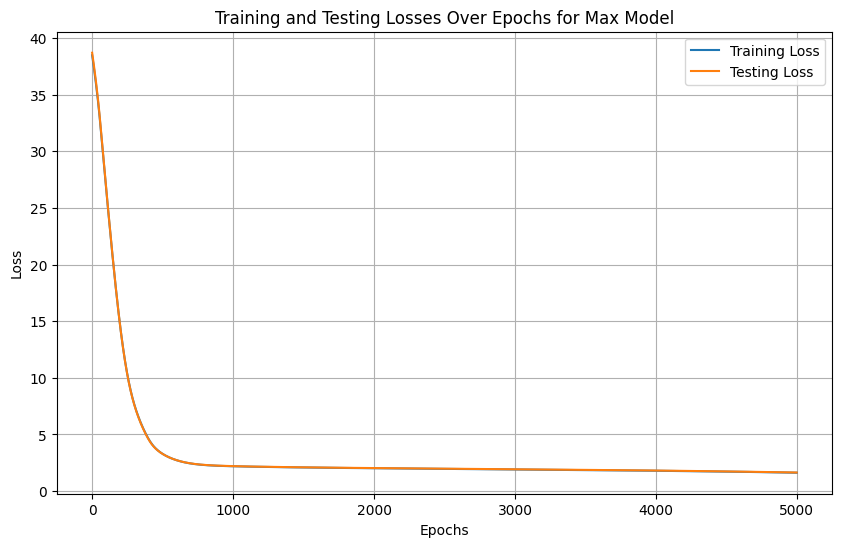

In [6]:
import matplotlib.pyplot as plt

best_model_info = filtered_df.sort_values(by="hidden_size").iloc[0]
best_hidden_size = int(best_model_info['hidden_size'])
print(f"Best model has {best_hidden_size} hidden units with testing loss {best_model_info['testing_loss']:.4f}")

torch.manual_seed(42)
test_samples = torch.rand(20000, 3) * 20 - 10
test_labels = torch.max(test_samples, dim=1, keepdim=True)[0]

input_size = 3
best_model = ReLU_MaxNN2(input_size, best_hidden_size)
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = best_model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        test_outputs = best_model(test_samples)
        test_loss = criterion(test_outputs, test_labels).item()
        test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

with torch.no_grad():
    predictions = best_model(test_samples)

print("\nTest Results:")
for i in range(100):
    sample = test_samples[i].numpy().round(2)
    true_avg = test_labels[i].item()
    pred = predictions[i].item()
    print(f"Sample {i+1}: {sample} | True: {true_avg:.2f} | Pred: {pred:.2f}")

mae = torch.mean(torch.abs(predictions - test_labels)).item()
print(f"\nMean Absolute Error: {mae:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses Over Epochs for Max Model')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import numpy as np
model_params = np.concatenate([
    param.data.numpy().flatten()
    for param in best_model.parameters()
])
np.save('training_weights_max.npy', model_params)

print("Model saved with parameter shape:", model_params.shape)
print("parameters:", model_params)

Model saved with parameter shape: (36,)
parameters: [ 4.4049355e-01 -6.5013868e-01  3.0294535e-01  3.6545977e-01
  3.3440459e-01  7.5898433e-01 -4.0414715e-01  3.0438313e-01
  2.6072821e-01  1.9825459e-01 -1.5431918e-01  2.5659138e-01
  3.4796780e-01  6.4997572e-01 -7.2413361e-01  9.2074698e-01
  2.9571498e-02 -1.0623845e+00 -1.7886111e-04 -3.2406163e-01
 -3.5750297e-01  1.5024623e+00 -8.5184610e-01  1.3564979e+00
 -1.9338031e+00  1.3171875e+00  6.4054996e-01  2.2628241e+00
  9.8576146e-01  3.0255020e-01  9.8096597e-01 -7.6458836e-01
  4.9079806e-01  3.2921913e-01 -9.2270833e-01 -5.0378942e-01]
